In [ ]:
#RAHUL S HOSKERI (rhoskeri@ucmerced.edu)

# Instructions to run the notebook file
# --------------------------------------
# 1) Place the folder with audio recordings and name it as "Recordings" and place the image_names_classes.csv file in the *** same directory *** where the notebook file is.

# 2) Launch the notebook file with name "EECS-207_CBIR-Rahul.ipynb" and run all.

# This will create all the folders necessary and perform all steps necessary to generate the graph.

# Compute Spectogram from the audio recording 
# Identify the ROIs from the spectrum
# Feature extraction of the dataset
# Query images against the rest and calculate precision and recall

In [173]:
# Import section
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import os
import pandas as pd
from scipy import signal
from scipy import ndimage as nd
from scipy import signal as sg
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

In [ ]:
# Compute Spectogram from the audio recording 

In [ ]:
# Expect the sampling rate to be the same for all recordings.
sampling_rate_expected = 44100

# The window size for the spectrogram.
window_size = 1024

# The window overlap for the spectrogram.
window_overlap = 512

In [ ]:
cwd=os.getcwd()
# The directory where the .wav files are located. We will read these.
recording_dir = cwd +'/Recordings/'

# The directory where we will write the computed spectrograms as .png image files.
spectrogram_dir = cwd +'/Spectrograms/'

try:
    os.makedirs(spectrogram_dir)
except:
    pass


In [ ]:
# Write spectrogram parameters.
parameters_filename = spectrogram_dir + '0_spectrogram_parameters.txt'
spectogram_param_file = open(parameters_filename,'w')
spectogram_param_file.write('sampling rate = '+ repr(sampling_rate_expected)+'\n')
spectogram_param_file.write('window size = '+ repr(window_size)+'\n')
spectogram_param_file.write('window overlap = '+ repr(window_overlap)+'\n')
spectogram_param_file.write('log10 of spectrum\n')
spectogram_param_file.close()

In [ ]:
# Get list of recordings.
recording_list = os.listdir(recording_dir);
n_recordings = len(recording_list)
print(n_recordings)

In [ ]:
# Read each recording and compute spectrogram
recording_num = 0
for recording in recording_list:
    recording_num = recording_num + 1
    recording_filename = recording_dir + recording
#     print('recording '+repr(recording_num)+' of '+repr(n_recordings)+': about to read '+recording)
    # Read the audio file. Don't change the sample rate.
    x, sampling_rate = librosa.load(recording_filename,sr=None)
    
    if sampling_rate != sampling_rate_expected:
        print('WRONG SAMPLING RATE: expected='+repr(sampling_rate_expected)+' recording='+repr(sampling_rate))
        break
        
    # Compute the spectrogram.
    w, t, s = signal.spectrogram(x, sampling_rate, noverlap=window_overlap, nperseg=window_size)
    
    # s: matrix with the 2D spectrogram (will be complex).
    # w: vector with the frequencies spacings of the computed DFT.
    # t: vector with the time spacings of the windows.

    # Compute the spectrum of the spectrogram.
    s_spectrum = abs(s);
    
    # Flip it vertically.
    s_spectrum = np.flip(s_spectrum, 0)

    # Compute log_10 of spectrogram.
    s_spectrum_log = np.log10( s_spectrum + np.finfo(float).eps )
    #plt.imshow(s_spectrum_log,cmap='gray')
    
    # Normalize so values range from 0 to 1.
    s_spectrum_log = (s_spectrum_log - np.amin(s_spectrum_log)) / (np.amax(s_spectrum_log) - np.amin(s_spectrum_log))

    # Save as png file.
    spectrogram_filename = spectrogram_dir + recording +'.png'
    plt.imsave(spectrogram_filename, s_spectrum_log, cmap='gray')

    # Save time and frequency indices.
    spectrograminfo_filename = spectrogram_dir + recording + '_info.txt'
    spectrograminfo_file = open(spectrograminfo_filename,'w')    
    for i in t:
        spectrograminfo_file.write(repr(i)+'\n')
    for i in w:
        spectrograminfo_file.write(repr(i)+'\n')
    spectrograminfo_file.close()

In [ ]:
# Identify the ROIs from the spectrum

In [ ]:
# Import section
import pandas as pd
from PIL import Image, ImageDraw

In [ ]:
# root_dir of where to put annotated spectrograms, etc.
root_dir = cwd+'/ROIs/'

# Where the computed spectrograms are located.
spectrogram_dir = cwd+'/Spectrograms/'

# Where the ROI .csv files are located.
rois_dir = cwd+'/ROIs/'

# The .csv file with the info about the ROIs.
rois_info_file = cwd+'/ROIs/birds.csv'

# Read the ROI info.
rois_info = pd.read_csv(rois_info_file)

n_birds = 5;


In [ ]:
# For each bird, read the ROI file and process the ROIs.
#for i in range(1):
for i in range(n_birds):
#     print("bird num",i)
    # Read ROI .csv file for this bird.
    roi_csv_file = rois_dir + rois_info['roi_file'][i]
    bird_rois_info = pd.read_csv(roi_csv_file);
#     print(bird_rois_info.head(5))
    n_rois = rois_info['roi_count'][i]
    # Process each ROI for this bird.
    for j in range(n_rois):
#    for j in range(2):
#        print(j)
        # Always get original spectroram.
        recording = bird_rois_info['recording'][j]
        spectrogram = recording + '.png'
        spectrogram_filename = spectrogram_dir + spectrogram
#         print(spectrogram_filename)
        spectrogram_image = plt.imread(spectrogram_filename)
#         plt.imshow(spectrogram_image,cmap='gray')
        
        # Check to see if this spectrogram has already been marked with an ROI.
        spectrogram_roi = recording + '.roi.png'
        spectrogram_roi_filename = root_dir + rois_info['bird'][i] + '/' + spectrogram_roi
#         print(spectrogram_roi_filename)
        
        if os.path.exists(spectrogram_roi_filename):
            # Read already marked up spectrogram.
            spectrogram_roi_image_PIL = Image.open(spectrogram_roi_filename);
        else:
            try:
                os.makedirs(root_dir + rois_info['bird'][i])
            except:
                pass
            spectrogram_roi_image_PIL = Image.open(spectrogram_filename);

        # Get size of spectrogram.
        n_rows = np.shape(spectrogram_image)[0]
        n_cols = np.shape(spectrogram_image)[1]
            
        # Get time and frequency coordinates of spectrogram from _info.txt file.
        spectrogram_info = recording + '_info.txt'
        spectrogram_info_filename = spectrogram_dir + spectrogram_info
        spectrograminfo_file = open(spectrogram_info_filename,'r')

        time_coords = np.zeros(n_cols)
        for x in range(n_cols):
            time_coords[x] = spectrograminfo_file.readline()
        freq_coords = np.zeros(n_rows)
        for x in range(n_rows):
            freq_coords[x] = spectrograminfo_file.readline()
        spectrograminfo_file.close()
        # Reverse.
        freq_coords = np.flip(freq_coords)
        
        # Find pixel bounds of ROI.
        top_left_row = np.where(freq_coords < bird_rois_info['y2'][j])
 #       print(top_left_row[0][0])
        bottom_right_row = np.where(freq_coords < bird_rois_info['y1'][j])
 #       print(bottom_right_row[0][0])
        top_left_col = np.where(time_coords > bird_rois_info['x1'][j])
#        print(top_left_col[0][0])
        bottom_right_col = np.where(time_coords > bird_rois_info['x2'][j])
#        print(bottom_right_col[0][0])
        width = bottom_right_col[0][0] - top_left_col[0][0] + 1;
        height = bottom_right_row[0][0] - top_left_row[0][0] + 1;
#        print(width)
#        print(height)
        
        # Draw rectangle.
        img1 = ImageDraw.Draw(spectrogram_roi_image_PIL)  
        img1.rectangle([(top_left_col[0][0],top_left_row[0][0]),(bottom_right_col[0][0],bottom_right_row[0][0])], outline ='white')
#        spectrogram_roi_image_PIL.show()
        
        # Save spectrogram with marked ROIs.
        spectrogram_roi_image_PIL.save(spectrogram_roi_filename)
        
        # Extract and save ROI.
        image_roi = spectrogram_image[top_left_row[0][0]-1:bottom_right_row[0][0]-1, top_left_col[0][0]-1:bottom_right_col[0][0]-1]
        image_roi_filename = root_dir+rois_info['bird'][i]+'/ROIs/'+rois_info['bird'][i]+'_'+repr(bird_rois_info['id'][j])+'.png'
        
        if os.path.exists(root_dir+rois_info['bird'][i]+'/ROIs/'):
#             print(image_roi_filename)
            plt.imsave(image_roi_filename, image_roi, cmap='gray')
        else:
            try:
                os.makedirs(root_dir+rois_info['bird'][i]+'/ROIs/')
            except:
                pass
            plt.imsave(image_roi_filename, image_roi, cmap='gray')

In [ ]:
# Feature extraction

In [ ]:
import shutil

In [ ]:
#Create folders if not existing
try:
    os.makedirs(cwd+'/features')
    os.makedirs(cwd+'/images')
except:
    pass

#Logic to copy ROI's calculated to one folder named 'image' for feature extraction
if len(os.listdir(cwd+'/images'))==0:
    for i in os.listdir(cwd+'/ROIs'):
        if os.path.isdir(cwd+'/ROIs/'+i):
            if len(os.listdir(cwd+'/ROIs/'+i+'/ROIs/'))==0:
                print("Folder of ROI empty")
            else:
                for j in os.listdir(cwd+'/ROIs/'+i+'/ROIs/'):
                    shutil.copy(cwd+'/ROIs/'+i+'/ROIs/'+j,cwd+'/images')
else:
    pass
#     print("Files exist in image folder")

# Location of images.
image_dir = cwd + '/images/'

# Location of where to write features.
feature_dir = cwd + '/features/'

# The .csv file containing the image names and classes.
image_file = cwd + '/image_names_classes.csv'

In [ ]:
# Number of images.
n_images = 218

# Read image names and classes .csv file.
image_names_classes = pd.read_csv(image_file, header=None )
# print(image_names_classes[1][0])

### Mean_Std Feature

In [ ]:
# Simple features have dimension 2
fdim = 2

features = np.zeros((n_images, fdim))

In [ ]:
# Extract features std_mean for each image.
for i in range(n_images):
    
    # Read the image.
    filename = image_dir + image_names_classes[0][i]
    im = plt.imread(filename)
#     print(im.shape)
    # It turns out that the spectrogram images saved using plt.imsave have four channels
    # RGBA. The RGB channels are each equal to the grayscale value so we can use any of them.
        
    # Compute the mean of the grayscale image as the first feature dimension.
    features[i,0] = np.mean(im[:,:,0])
    
    # Compute the standard deviation of the grayscale image as the second feature dimension.
    features[i,1] = np.std(im[:,:,0])

In [ ]:
# Save the features as a .csv file.
feature_filename = feature_dir + 'mean_stdev.txt'

np.savetxt(feature_filename, features, delimiter=',')

In [ ]:
# # Simple features have dimension 2
# fdim = 1
# features = np.zeros((n_images, fdim))

In [ ]:
# # Extract feature mean for each image.
# for i in range(n_images):
    
#     # Read the image.
#     filename = image_dir + image_names_classes[0][i]
#     im = plt.imread(filename)
# #     print(im.shape)
#     # It turns out that the spectrogram images saved using plt.imsave have four channels
#     # RGBA. The RGB channels are each equal to the grayscale value so we can use any of them.
        
#     # Compute the mean of the grayscale image as the first feature dimension.
# #     print(i)
#     features[i] = np.mean(im[:,:,0])


In [ ]:
# feature_filename = feature_dir + 'mean.txt'
# # print(features)
# np.savetxt(feature_filename, features, delimiter=',')

In [ ]:
# # Simple features have dimension 2
# fdim = 1
# features = np.zeros((n_images, fdim))

In [ ]:
# # Extract feature standard_deviation mean for each image.
# for i in range(n_images):
    
#     # Read the image.
#     filename = image_dir + image_names_classes[0][i]
#     im = plt.imread(filename)
# #     print(im.shape)
#     # It turns out that the spectrogram images saved using plt.imsave have four channels
#     # RGBA. The RGB channels are each equal to the grayscale value so we can use any of them.
        
#     # Compute the mean of the grayscale image as the first feature dimension.
#     features[i] = np.std(im[:,:,0])

In [ ]:
# feature_filename = feature_dir + 'std.txt'

# np.savetxt(feature_filename, features, delimiter=',')

### Gabor Filters

In [ ]:
### Gabor Features 2 scale and 3 orientation ###

# prepare filter bank kernels
kernels = []
# EXPERIMENT WITH THE NUMBER OF ORIENTATIONS.
# MAKE SURE TO CHANGE THE FEATURE FILENAME BELOW TO INDICATE THE NUMBER OF ORIENTATIONS: Gabor_Y_X_.txt
# WHERE X IS THE NUMBER OF SCALES AND Y IS THE NUMBER OF ORIENTATIONS.
norientations = 3
scales=len([0.05, 0.25])
for theta in range(norientations):
    theta = theta / norientations * np.pi
    # EXPERIMENT WITH THE NUMBER OF SCALES AND THE FREQUENCIES OF THE FILTERS.
#    for frequency in (0.05, 0.1, 0.20, 0.4):
    for frequency in (0.05, 0.25):
        kernel = gabor_kernel(frequency, theta=theta)
        kernels.append(kernel)
        
fig, axs = plt.subplots(1, len(kernels), figsize=(20,20))
for k, kernel in enumerate(kernels):
    axs[k].imshow(np.real(kernel),cmap='gray')
    
fig, axs = plt.subplots(1, len(kernels), figsize=(20,20))
for k, kernel in enumerate(kernels):
    axs[k].imshow(np.imag(kernel),cmap='gray')


In [ ]:
# Mean and standard deviation will be computed for each filter output.
fdim = 2 * len(kernels)

features = np.zeros((n_images, fdim))

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels) * 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = sg.convolve(image, kernel)
        feats[2*k] = np.abs(filtered).mean()
        feats[2*k+1] = np.abs(filtered).std()
    return feats

In [ ]:
# Extract features for each image.
for i in range(n_images):
    
    # Read the image.
    filename = image_dir + image_names_classes[0][i]    
    im = plt.imread(filename)
    
    # It turns out that the spectrogram images saved using plt.imsave have four channels
    # RGBA. The RGB channels are each equal to the grayscale value so we can use any of them.
    
    features[i, :] = compute_feats(im[:,:,0], kernels)
    
# Save the features as a .csv file.
gabor_filename='Gabor'+'_'+str(scales)+'_'+str(norientations)+'.txt'
feature_filename = feature_dir +  gabor_filename

np.savetxt(feature_filename, features, delimiter=',')

In [ ]:
### Gabor Features 3 scale and 5 orientation ###

# prepare filter bank kernels
kernels = []
# EXPERIMENT WITH THE NUMBER OF ORIENTATIONS.
# MAKE SURE TO CHANGE THE FEATURE FILENAME BELOW TO INDICATE THE NUMBER OF ORIENTATIONS: Gabor_Y_X_.txt
# WHERE X IS THE NUMBER OF SCALES AND Y IS THE NUMBER OF ORIENTATIONS.
norientations = 5
scales=len([0.05, 0.1, 0.20])
for theta in range(norientations):
    theta = theta / norientations * np.pi
    # EXPERIMENT WITH THE NUMBER OF SCALES AND THE FREQUENCIES OF THE FILTERS.
#    for frequency in (0.05, 0.1, 0.20, 0.4):
    for frequency in (0.05, 0.1, 0.20):
        kernel = gabor_kernel(frequency, theta=theta)
        kernels.append(kernel)
        
fig, axs = plt.subplots(1, len(kernels), figsize=(20,20))
for k, kernel in enumerate(kernels):
    axs[k].imshow(np.real(kernel),cmap='gray')
    
fig, axs = plt.subplots(1, len(kernels), figsize=(20,20))
for k, kernel in enumerate(kernels):
    axs[k].imshow(np.imag(kernel),cmap='gray')


In [ ]:
# Mean and standard deviation will be computed for each filter output.
fdim = 2 * len(kernels)

features = np.zeros((n_images, fdim))

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels) * 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = sg.convolve(image, kernel)
        feats[2*k] = np.abs(filtered).mean()
        feats[2*k+1] = np.abs(filtered).std()
    return feats

In [ ]:
# Extract features for each image.
for i in range(n_images):
    
    # Read the image.
    filename = image_dir + image_names_classes[0][i]    
    im = plt.imread(filename)
    
    # It turns out that the spectrogram images saved using plt.imsave have four channels
    # RGBA. The RGB channels are each equal to the grayscale value so we can use any of them.
    
    features[i, :] = compute_feats(im[:,:,0], kernels)
    
# Save the features as a .csv file.
gabor_filename='Gabor'+'_'+str(scales)+'_'+str(norientations)+'.txt'
feature_filename = feature_dir + gabor_filename

np.savetxt(feature_filename, features, delimiter=',')

#### Queries part of code ####

In [142]:
# Dictionaries to store precision and recall for the queries performed
from collections import OrderedDict
import math
import os
mean_std_L1= OrderedDict()
mean= OrderedDict()
std= OrderedDict()
Gabor2_3_L1= OrderedDict()
Gabor3_5_L1= OrderedDict()

mean_std_L2= OrderedDict()
Gabor2_3_L2= OrderedDict()
Gabor3_5_L2= OrderedDict()

In [143]:
def prec_recal(prec_num,prec_denom,recal_num,recal_denom):
    return (prec_num/prec_denom,recal_num/recal_denom)

In [144]:
#Dictionary to store the class and class size of birds
bird_class_size_dict=OrderedDict()
rois_info = pd.read_csv(rois_info_file)

#Store the class and class size of birds
for i in range(len(list(rois_info['bird']))):
    bird_class_size_dict[i+1]=rois_info['roi_count'].iloc[i]

# Number of images.
n_images = 218

### L1 Distance

In [145]:
for i in os.listdir(feature_dir):
    if i.split(".")[1]=='txt':
        feature_filename = feature_dir + i
        features = np.genfromtxt(feature_filename, delimiter=',')
        fdim = np.shape(features)[1]
        print(i,fdim)
        
        for query_image in range(n_images):
            # Compute Euclidean distance between query feature vector and each image's feature vector.
            distances = np.zeros(n_images)
            
            for j in range(n_images):
                distances[j] = 0
                for k in range(fdim):
                    distances[j] = distances[j] + ((features[query_image][k] - features[j][k])**2)
                distances[j] = distances[j] ** 0.5
                
            # Get the indices of the sorted distances.
            sorted_index = np.argsort(distances)
            #Get the class and class size of query image
            class_qimg=image_names_classes[1][query_image]
            class_qimg_size= bird_class_size_dict[class_qimg]

            temp_prec_arr=[]
            temp_recal_arr=[]

            # Retrieve top k images.
            for k in range(1,n_images+1):
                prec_num=0
                prec_denom=k
                recal_denom=class_qimg_size
                recal_num=0
                for z in sorted_index[0:k]:
                    if class_qimg==image_names_classes[1][z]:
                        prec_num+=1
                        recal_num+=1
                temp_prec_arr.append(prec_num/prec_denom)
                temp_recal_arr.append(recal_num/recal_denom)
                
            if i=="Gabor_2_3.txt":
                Gabor2_3_L1[query_image]=[temp_prec_arr,temp_recal_arr]
            if i=="Gabor_3_5.txt":
                Gabor3_5_L1[query_image]=[temp_prec_arr,temp_recal_arr]
            if i=="mean_stdev.txt":
                mean_std_L1[query_image]=[temp_prec_arr,temp_recal_arr]
                    
                    
                    
            

Gabor_2_3.txt 12
Gabor_3_5.txt 30
mean_stdev.txt 2


### L2 Distance

In [146]:
for i in os.listdir(feature_dir):
    if i.split(".")[1]=='txt':
        feature_filename = feature_dir + i
        features = np.genfromtxt(feature_filename, delimiter=',')
        fdim = np.shape(features)[1]
        print(i,fdim)
        
        for query_image in range(n_images):
            # Compute Euclidean distance between query feature vector and each image's feature vector.
            distances = np.zeros(n_images)
            
            for j in range(n_images):
                distances[j] = 0
                for k in range(fdim):
                    distances[j] = distances[j] + (abs(features[query_image][k] - features[j][k]))
                
            # Get the indices of the sorted distances.
            sorted_index = np.argsort(distances)
            #Get the class and class size of query image
            class_qimg=image_names_classes[1][query_image]
            class_qimg_size= bird_class_size_dict[class_qimg]

            temp_prec_arr=[]
            temp_recal_arr=[]

            # Retrieve top k images.
            for k in range(1,n_images+1):
                prec_num=0
                prec_denom=k
                recal_denom=class_qimg_size
                recal_num=0
                for z in sorted_index[0:k]:
                    if class_qimg==image_names_classes[1][z]:
                        prec_num+=1
                        recal_num+=1
                temp_prec_arr.append(prec_num/prec_denom)
                temp_recal_arr.append(recal_num/recal_denom)
                
            if i=="Gabor_2_3.txt":
                Gabor2_3_L2[query_image]=[temp_prec_arr,temp_recal_arr]
            if i=="Gabor_3_5.txt":
                Gabor3_5_L2[query_image]=[temp_prec_arr,temp_recal_arr]
            if i=="mean_stdev.txt":
                mean_std_L2[query_image]=[temp_prec_arr,temp_recal_arr]

Gabor_2_3.txt 12
Gabor_3_5.txt 30
mean_stdev.txt 2


### Interpolate Precision for fixed recall values

In [159]:
pre_defined_recal=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [166]:
#Empty dictionaries to hold the interpolated values
mean_std_L1_p_r= OrderedDict()
Gabor2_3_L1_p_r= OrderedDict()
Gabor3_5_L1_p_r= OrderedDict()

mean_std_L2_p_r= OrderedDict()
Gabor2_3_L2_p_r= OrderedDict()
Gabor3_5_L2_p_r= OrderedDict()


In [167]:
#Function to return the interpolated precision value

def interpolate_p_r(p_arr,r_arr):
    temp_p=[]
    for i in pre_defined_recal: 
        for j in range(len(r_arr)):
            if r_arr[j]>=i:
                temp_p.append(p_arr[j])
                break
    return temp_p
    
    

In [168]:
#interpolate for L1 measure
for k,v in mean_std_L1.items():
    ans=interpolate_p_r(v[0],v[1])
    mean_std_L1_p_r[k]=ans
    
for k,v in Gabor2_3_L1.items():
    ans=interpolate_p_r(v[0],v[1])
    Gabor2_3_L1_p_r[k]=ans
    
for k,v in Gabor3_5_L1.items():
    ans=interpolate_p_r(v[0],v[1])
    Gabor3_5_L1_p_r[k]=ans
    

In [169]:
#interpolate for L2 measure
for k,v in mean_std_L2.items():
    ans=interpolate_p_r(v[0],v[1])
    mean_std_L2_p_r[k]=ans
    
for k,v in Gabor2_3_L2.items():
    ans=interpolate_p_r(v[0],v[1])
    Gabor2_3_L2_p_r[k]=ans
    
for k,v in Gabor3_5_L2.items():
    ans=interpolate_p_r(v[0],v[1])
    Gabor3_5_L2_p_r[k]=ans

In [190]:
#Aggregate the interpolated precision values for recal values
mean_std_L1_res=np.zeros(11)
for k,v in mean_std_L1_p_r.items():
    mean_std_L1_res=np.add(mean_std_L1_res,v)
for i in range(len(mean_std_L1_res)):
    mean_std_L1_res[i]=mean_std_L1_res[i]/218
    
Gabor2_3_L1_res=np.zeros(11)
for k,v in Gabor2_3_L1_p_r.items():
    Gabor2_3_L1_res=np.add(Gabor2_3_L1_res,v)
for i in range(len(Gabor2_3_L1_res)):
    Gabor2_3_L1_res[i]=Gabor2_3_L1_res[i]/218
    
Gabor3_5_L1_res=np.zeros(11)
for k,v in Gabor3_5_L1_p_r.items():
    Gabor3_5_L1_res=np.add(Gabor3_5_L1_res,v)
for i in range(len(Gabor3_5_L1_res)):
    Gabor3_5_L1_res[i]=Gabor3_5_L1_res[i]/218
    
    

In [194]:
#Aggregate the interpolated precision values for recal values
mean_std_L2_res=np.zeros(11)
for k,v in mean_std_L2_p_r.items():
    mean_std_L2_res=np.add(mean_std_L2_res,v)
for i in range(len(mean_std_L2_res)):
    mean_std_L2_res[i]=mean_std_L2_res[i]/218
    
Gabor2_3_L2_res=np.zeros(11)
for k,v in Gabor2_3_L2_p_r.items():
    Gabor2_3_L2_res=np.add(Gabor2_3_L2_res,v)
for i in range(len(Gabor2_3_L2_res)):
    Gabor2_3_L2_res[i]=Gabor2_3_L2_res[i]/218
    
Gabor3_5_L2_res=np.zeros(11)
for k,v in Gabor3_5_L2_p_r.items():
    Gabor3_5_L2_res=np.add(Gabor3_5_L2_res,v)
for i in range(len(Gabor3_5_L2_res)):
    Gabor3_5_L2_res[i]=Gabor3_5_L2_res[i]/218

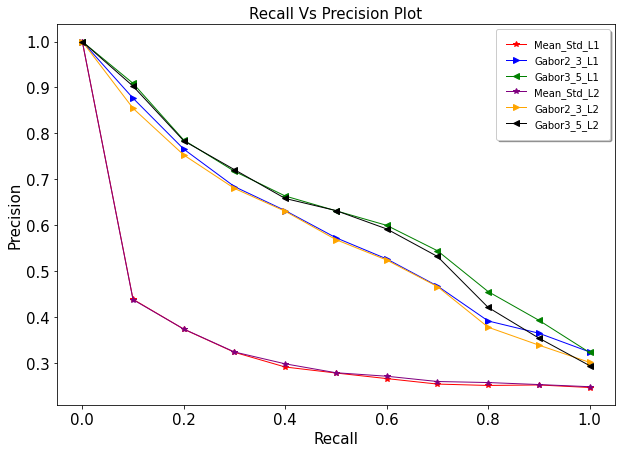

In [238]:
#Plot the final interpolated graph

fig=plt.figure(figsize=(10,7))
x=pre_defined_recal

y1=mean_std_L1_res
y2=Gabor2_3_L1_res
y3=Gabor3_5_L1_res

y4=mean_std_L2_res
y5=Gabor2_3_L2_res
y6=Gabor3_5_L2_res

plt.plot(x,y1,'*r-',linewidth=1,label="Mean_Std_L1")
plt.plot(x,y2,'>b-',linewidth=1,label="Gabor2_3_L1")
plt.plot(x,y3,'<g-',linewidth=1,label="Gabor3_5_L1")

plt.plot(x,y4,'*y-',color="purple",linewidth=1,label="Mean_Std_L2")
plt.plot(x,y5,'>-', color="orange",linewidth=1,label="Gabor2_3_L2")
plt.plot(x,y6,'<-',color="black",linewidth=1,label="Gabor3_5_L2")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize=10)
plt.title("Recall Vs Precision Plot",fontsize=15)
plt.xlabel("Recall",fontsize=15)
plt.ylabel("Precision",fontsize=15)
plt.savefig(cwd+"/"+"precision vs recall.png")
plt.show()

In [237]:
#Average Precision values
print("       Average Precision Values       ")
print("--------------------------------------")
print("Mean_Std_L1 ||",np.mean(mean_std_L1_res))
print("--------------------------------------")
print("Gabor2_3_L1 ||",np.mean(Gabor2_3_L1_res))
print("--------------------------------------")
print("Gabor3_5_L1 ||",np.mean(Gabor3_5_L1_res))
print("--------------------------------------")
print("Mean_Std_L2 ||",np.mean(mean_std_L2_res))
print("--------------------------------------")
print("Gabor2_3_L2 ||",np.mean(Gabor2_3_L2_res))
print("--------------------------------------")
print("Gabor2_3_L2 ||",np.mean(Gabor3_5_L2_res))
print("--------------------------------------")


       Average Precision Values       
--------------------------------------
Mean_Std_L1 || 0.3610683856099536
--------------------------------------
Gabor2_3_L1 || 0.6003521514370342
--------------------------------------
Gabor3_5_L1 || 0.6382708592748849
--------------------------------------
Mean_Std_L2 || 0.36354809342441036
--------------------------------------
Gabor2_3_L2 || 0.5903209531093951
--------------------------------------
Gabor2_3_L2 || 0.6263292223471217
--------------------------------------
